# Deep Residual Learning for Image Recognition

## 0. Paper

### Info
* Title: Deep Residual Learning for Image Recognition
* Author: Kaiming He et al.
* Link: https://arxiv.org/pdf/1512.03385.pdf

### Summary
* We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

### Features
* Dataset: CIFAR-10
* Optimizer: Adam

### Reference
* https://github.com/tensorflow/tensorflow/blob/v2.4.0/tensorflow/python/keras/applications/resnet.py#L475-L493
* https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py


## 1. Setting

In [1]:
# Libraries
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [4]:
# Hyperparameters
BASE_DIR = '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'

## 2. Data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## 3. Model

In [7]:
class Padding(tf.keras.layers.Layer):
    """
    Data augmentation을 위해 Padding 진행
    """
    def __init__(self):
        super(Padding, self).__init__()

    def call(self, x, training):
        if not training:
            return x
        x = tf.pad(x, [[0, 0], [4, 4], [4, 4], [0, 0]])
        return x

def create_data_augment():
    data_augment = tf.keras.Sequential([
        Padding(),
        tf.keras.layers.experimental.preprocessing.RandomCrop(32, 32),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
    ])
    return data_augment

In [8]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, downsample=False):
        super(ResidualBlock, self).__init__()
        if downsample:
            self.shortcut_layer = tf.keras.layers.Conv2D(filters * 4, 1, 2)
        else:
            self.shortcut_layer = tf.identity
        
        if downsample:
            self.conv1 = tf.keras.layers.Conv2D(filters, 1, 2)
        else:
            self.conv1 = tf.keras.layers.Conv2D(filters, 1, 1)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(filters, 3, 1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(filters * 4, 1, 1)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()

    def call(self, x):
        shortcut = self.shortcut_layer(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += shortcut
        x = self.relu3(x)
        return x

In [9]:
def create_model():
    inputs = tf.keras.layers.Input((32, 32, 3))
    x = create_data_augment()(inputs)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1.)(x)

    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = ResidualBlock(16, downsample=True)(x)
    for _ in range(35):
        x = ResidualBlock(16)(x)
    
    x = ResidualBlock(32, downsample=True)(x)
    for _ in range(35):
        x = ResidualBlock(32)(x)
    
    x = ResidualBlock(64, downsample=True)(x)
    for _ in range(35):
        x = ResidualBlock(64)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [10]:
model = create_model()

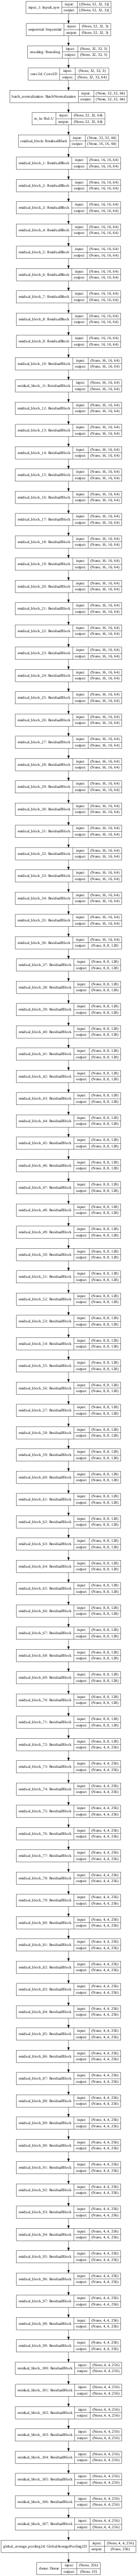

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=36)

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

## 4. Experiment

In [13]:
hist = model.fit(
    x_train, y_train,
    validation_split = 0.2,
    batch_size = 128,
    epochs = 100,
)

Epoch 1/100
313/313 [==============================] - 83s 159ms/step - loss: 3.3405 - acc: 0.1372 - val_loss: 3.7323 - val_acc: 0.1088
Epoch 2/100
313/313 [==============================] - 44s 141ms/step - loss: 2.0637 - acc: 0.2654 - val_loss: 1.9113 - val_acc: 0.3224
Epoch 3/100
313/313 [==============================] - 44s 141ms/step - loss: 1.8667 - acc: 0.3254 - val_loss: 1.8139 - val_acc: 0.3721
Epoch 4/100
313/313 [==============================] - 44s 142ms/step - loss: 1.7243 - acc: 0.3798 - val_loss: 1.8505 - val_acc: 0.4076
Epoch 5/100
313/313 [==============================] - 44s 142ms/step - loss: 1.6353 - acc: 0.4123 - val_loss: 1.7464 - val_acc: 0.4246
Epoch 6/100
313/313 [==============================] - 45s 142ms/step - loss: 1.5669 - acc: 0.4388 - val_loss: 1.9329 - val_acc: 0.4361
Epoch 7/100
313/313 [==============================] - 44s 142ms/step - loss: 1.5100 - acc: 0.4618 - val_loss: 1.4811 - val_acc: 0.4585
Epoch 8/100
313/313 [===========================

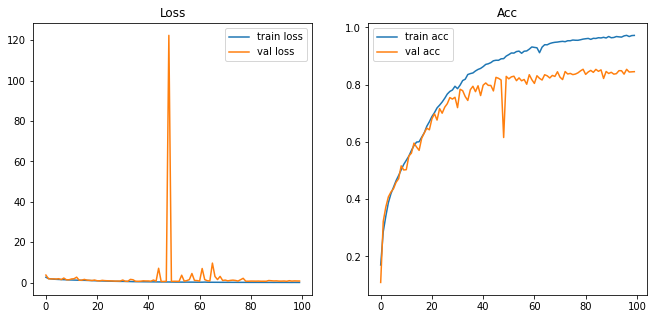

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_title('Loss')
ax[0].legend(['train loss', 'val loss'])

ax[1].plot(hist.history['acc'])
ax[1].plot(hist.history['val_acc'])
ax[1].set_title('Acc')
ax[1].legend(['train acc', 'val acc'])

plt.show()

In [15]:
_ = model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.8776 - acc: 0.8373
